In [6]:

import requests
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM

# Fetch data from the API for training (1 year) and testing (1 month)
url_train = "https://api.energy-charts.info/price?bzn=DE-LU&start=2024-01-01&end=2024-09-01"
url_test = "https://api.energy-charts.info/price?bzn=DE-LU&start=2024-09-01&end=2024-10-01"

response_train = requests.get(url_train)
response_test = requests.get(url_test)

data_train = response_train.json()
data_test = response_test.json()

# Convert to DataFrame
train_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_train['unix_seconds'], unit='s'),
    'price': data_train['price']
})
test_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_test['unix_seconds'], unit='s'),
    'price': data_test['price']
})

# Clean the data (remove rows with null prices)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Rename columns for NeuralForecast
train_df = train_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
test_df = test_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
train_df['unique_id'] = 'electricity_prices'
test_df['unique_id'] = 'electricity_prices'

# Check date ranges
print("Last date in train_df:", train_df['ds'].max())
print("First date in test_df:", test_df['ds'].min())



Last date in train_df: 2024-09-01 21:00:00
First date in test_df: 2024-08-31 22:00:00


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
import pandas as pd
import matplotlib.pyplot as plt

# Set up the model with horizon = 24 (for day-ahead hourly forecasts)
models = [
    LSTM(h=24,  # Forecast horizon set to 24 to predict the next day's 24 hours
         max_steps=200,  # Fewer training steps for faster computation
         scaler_type='standard',
         encoder_hidden_size=32,  # Reduced hidden size for faster training
         decoder_hidden_size=32),  
]

# Train the model on the entire training data just once
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=train_df)

# Prepare for day-by-day predictions with updated inputs
forecasted_values = []  # List to store day-by-day forecast results
input_df = train_df.copy()  # Start with the training data as initial input

# Iteratively forecast each day ahead in the test set
for i in range(0, len(test_df), 24):  # Step by 24 to predict day-by-day
    # Generate the forecast for the next day (24 hours)
    day_forecast = nf.predict().iloc[-24:]  # Take only the last 24-hour forecast

    # Append each hourly forecast to `forecasted_values`
    for j in range(24):
        forecasted_values.append({
            'ds': test_df.iloc[i + j]['ds'],  # Use the corresponding timestamp in test data
            'LSTM': day_forecast['LSTM'].values[j]
        })

    # Update `input_df` with the actual values from the current day in `test_df`
    next_day_actual = test_df.iloc[i:i + 24]  # Select the next 24 hours
    next_day_actual['unique_id'] = 'electricity_prices'  # Add unique_id to align with model input
    input_df = pd.concat([input_df, next_day_actual])

    # Update the NeuralForecast object with the extended input_df
    nf.fit(df=input_df)  # Optionally refit, though it adds overhead. Removing this will make it faster.

# Convert `forecasted_values` to a DataFrame for plotting
forecast_df = pd.DataFrame(forecasted_values)

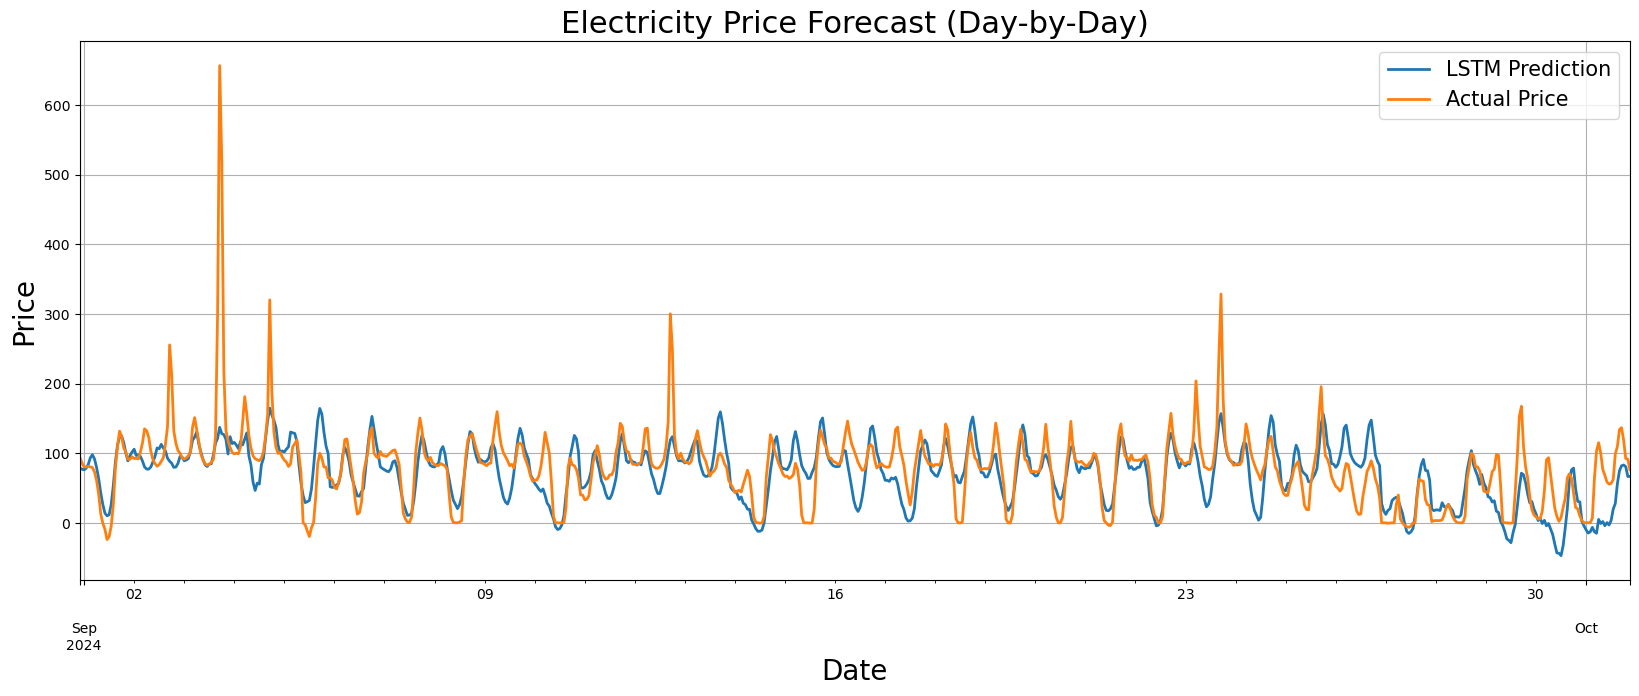

In [8]:
# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# Plot predictions for LSTM model
forecast_df.set_index('ds')['LSTM'].plot(ax=ax, linewidth=2, label='LSTM Prediction')

# Optional: Plot actual test values for comparison
test_df.set_index('ds')['y'].plot(ax=ax, linewidth=2, label='Actual Price')

# Formatting the plot
ax.set_title('Electricity Price Forecast (Day-by-Day)', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()

In [9]:
print(forecast_df.head(25))

                    ds        LSTM
0  2024-08-31 22:00:00   78.498154
1  2024-08-31 23:00:00   77.069717
2  2024-09-01 00:00:00   76.168518
3  2024-09-01 01:00:00   78.238312
4  2024-09-01 02:00:00   83.784821
5  2024-09-01 03:00:00   93.356468
6  2024-09-01 04:00:00   97.728859
7  2024-09-01 05:00:00   91.633652
8  2024-09-01 06:00:00   79.513344
9  2024-09-01 07:00:00   63.354179
10 2024-09-01 08:00:00   42.765022
11 2024-09-01 09:00:00   26.168888
12 2024-09-01 10:00:00   13.846397
13 2024-09-01 11:00:00   10.066502
14 2024-09-01 12:00:00   11.528255
15 2024-09-01 13:00:00   26.209980
16 2024-09-01 14:00:00   52.919731
17 2024-09-01 15:00:00   86.540131
18 2024-09-01 16:00:00  111.337669
19 2024-09-01 17:00:00  122.896652
20 2024-09-01 18:00:00  124.566444
21 2024-09-01 19:00:00  115.301849
22 2024-09-01 20:00:00  100.412689
23 2024-09-01 21:00:00   89.021507
24 2024-09-01 22:00:00   96.411598


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure forecast_df and test_df are aligned by 'ds' (date) to avoid mismatches
comparison_df = forecast_df.merge(test_df[['ds', 'y']], on='ds', how='inner')
comparison_df.rename(columns={'y': 'y_actual', 'LSTM': 'y_pred'}, inplace=True)

# Calculate the error metrics
mae = mean_absolute_error(comparison_df['y_actual'], comparison_df['y_pred'])
mse = mean_squared_error(comparison_df['y_actual'], comparison_df['y_pred'])
rmse = np.sqrt(mse)

# Print the results
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance:
Mean Absolute Error (MAE): 26.56
Mean Squared Error (MSE): 1846.57
Root Mean Squared Error (RMSE): 42.97
